## Пояснительная записка. 

### Немного о том, как я парсила данные.

 После распарсивания json'а и визуального :) анализа я определила, что текстовая информация, на которую интересно посмотреть, отвечает следующим условиям:
 
  - 0) тип данных (type) String, значние (value), соответственно, непустое И
  - 1) префикс, равный item.text - это чисто текстовые посты ИЛИ
  - 2) префикс, содержащий description - это тоже посты, но которые также содержат какой-то attachment (ссылка, подкаст, 
 альбом идт) и его описывают ИЛИ
  - 3) префикс, содержащий textcomment и заканчивающийся на text - это комменты ИЛИ
  - 4) префикс, содержащий title - это заголовки аттачметтов (может чего-нибудь еще): ссылок, видео, аудио итд

Условие 4) я решила не рассматривать, так как это не текст, который сочиняли авторы постов и комментариев.

Дальше я решила разделить тексты на 3 группы.
 1. комментарии - группа 3)
 2. посты от админов группы - группа 2) и частично 3)
 3. посты от участников группы - частично 3)

Зачем 2. и 3. вынесены в разные группы? Поясняю:

Мне кажется, что стиль изложения и цели в постах админов и участников будут разными, что будет отражено в частотных словах. И я хотела бы разнести их по разным группам, чтобы посмотреть на отличия.

А что за частично 3), которое входит в 2. и 3.?

 Дело в том, что с какого-то момента админы группы решили закрыть стенку для комментариев участников (где-то в 2015) или 
 **окончательно** закрыть стенку, потому что раньше закрывали ее на ограниченные периоды. В общем, я на глаз определила  (магическое число 795 в коде), с какого момента посты на стене становятся прерогативой исключительно админа, и эти посты идут в группу 2., а где в постах было значительное количество постов от участников (посты админа там тоже есть, но сравнительно мало), и эта часть была выделена в отдельную группу "посты участников".
 
*Вот после какого поста это событие происходит :)
 <br>prefix=item.text,value=Немного позанудствую... ДЛЯ ВОПРОСОВ ЕСТЬ СПЕЦИАЛЬНАЯ ТЕМА! Ну правда, стена группы - плохое место для одинаковых вопросов. Может, закроем ее на лето, как обычно?]*
 
### Немного выводов

Я не придумала чего-то конкретного, что можно было бы проанализировать, и решила попытаться сделать набор предположений о  результатах на основании разбиения на 3 группы.

**Пост пользователя (ПП)
<br> Пост админа (ПА)
<br> Комментарий (К)**

1. Количество постов/комментов и их объем

Comments : 14,113 comments, 1,232,477 symbols
<br>Admin posts : 1,612 posts, 605,300 symbols
<br>User posts : 4,019 posts, 951,894 symbols

<br>Avg Comment lenght :  87.33
<br>Avg Admin post lenght :  375.5
<br>Avg User post lenght :  236.85

Комментов ожидаемо намного больше, чем постов обоих видов. <br>Разница количества ПП и ПА (с учетом того, что админы единолично пишут посты примерно с 2015, то есть намного дольше, чем писали пользователи) тоже объясняется бОльшим количеством пользователей, чем админов + видимо, тем, что в постах пользователи писали в основном мноооооого вопросов, которые потом перенеслись в темы группы ЛШ.

Средний комментарий в 4 раза короче ПА и равен 87 символам, включая пробелы и знаки препинания. Кажется, что это больше, чем ожидаешь сегодня от комментария.
<br> Интересно, почему разница между ПП и ПА не такая большая. Я ожидала, что ПП будут покороче. Возможно, когда люди пишут на стене, то стараются изложить дело подробнее и понятнее, еще возможно, что в группу ПП закралось досаточное количество ПА, чтобы существенно увеличить среднюю длину поста.

2. В частотные словах ПА попали ссылки (токен https и letnyaya shkola), что понятно: в постах группы должна быть куча ссылок на сайт ЛШ, результаты работ участников и допольнительные материалы. Ни в ПА, ни в К ссылок часто не наблюдается.


3. В десятке самых частотных слов ПА (кроме ссылок) лш, мастерской, летней, школы и их склонения. Я уже знаю из задания 3 про стоп-слова, поэтому особенно интересно, что в десятке частотных слова ПА нет стоп-слов, в отличие от ПП и К. Я бы объяснила это большей "официальностью" стиля ПА, который требует доскональности в наименованиях, соответственно, везде надо добавлять "летней школы" (еще эти посты будут перепощивать, а значит людям не в теме должно быть понятно о чем речь).


4. ЛШ. Это единственное слово меньше 4 букв, которое я оставила. Ожидаемо, такое наименование встречается чаще, чем "летняя школа" во всех трех группах. <br>Но вот что интересно, для ПА "летней", "школы" - это 3, 4 по популярности слова. <br>Для ПП - эти слова чуть ниже (стоп-слова "будет", "очень", "можно" популярнее), НО "школа" на позицию выше, чем "летняя", а значит чаще пользователи уже используют неформальное "школа" вместо "летняя школа", что подтверждает авторство постов. <br>Для К "школа" съезжает намного ниже под кучей стоп-слов, а "летняя" вообще не входит в 30 самых популярных. Думаю, это объяняется краткостью комментов (конечно, "лш" удобнее, чем "школа" или, тем более, "летняя школа") и тем, что комменту часто не нужен контекст - он дополнение к посту, из которого скорее всего и так понятно, о чем речь.


5. Пожалуйста и спасибо. <br>Слова, которые совсем не популярны в ПА. Логично, потому что они в рамках группы скорее отвечают за формирование просьбы/вопроса и благодарности за предоставленную информацию. То есть админам такая цель послания не нужна (или не так часто, чтобы попасть в топ). А вот в ПП и К пожалуйста и спасибо уже наиболее частотсные. Что интересно, в ПП пожалуйста немного популярнее, чем спасибо, то есть ПП - это чаще вопросы с вежливым маркером "пожалуйста". А вот в К популярее спасибо (причем это второе по популярности слово после "будет"), то есть в К пользователи часто (ооочень часто) благодарят за ответ на вопрос в посте или в других комментариях.

------------------------------
<br>Функция, чтобы немного чистить текст и сформировать отсортированный словарь

In [8]:
def create_sorted_dict(text):
    # убрать пунктуацию и другие знаки
    punctuations = '''-[]{};:'"/\\/<>@#$%^&*_|—«»~=!().?,'''

    text = text.lower()
    
    # заменяем на пробелы, чтобы не слиплись слова в тех случаях, когда после запятой или точки не поставлен пробел
    # получается беда со ссылками, когда http www bla bla - это отдельные слова, но пусть это будет known issue
    for sybmol in text: 
        if sybmol in punctuations: 
            text = text.replace(sybmol, ' ')

    text_list = text.split()
    
    frequency_dict = {}
    
    # получаем частотный словарь
    for word in text_list:
        count = frequency_dict.get(word, 0)
        frequency_dict[word] = count + 1
    
    # сортируем частотный словарь
    sorted_tuples = sorted(frequency_dict.items(), key = lambda item: item[1], reverse = True)
    sorted_dict = {k: v for k, v in sorted_tuples}

    sorted_frequency_dict = sorted_dict

    # убираем слова меньше 5 букв, за исключением "лш"
    for key in list(sorted_dict.keys()):
        if(len(key) <= 4 and key != 'лш'):
            sorted_frequency_dict.pop(key)
            
    return(sorted_frequency_dict)

Функция, чтобы обрезать датасет и показать минимальную статистику

In [10]:
def trim_dict(dict, trim_count = 20):

    all_unique_words_count = len(dict)
    all_words_count = 0
    frequent_words_count = 0

    final_dict = {}
    count = 0

    for key, value in dict.items():
        all_words_count = all_words_count + value
        if count < trim_count:
            count += 1
            frequent_words_count = frequent_words_count + value
            final_dict[key] = value

    print('Number of unique words :', all_unique_words_count)
    print('Number of all words :', all_words_count)
    print('Number of', trim_count, 'most frequent words :', frequent_words_count)
    print(str(trim_count) + ' most frequent words is '+ str(round(trim_count/all_unique_words_count*100, 2)) 
          + '% of unique words and ' + str(round(frequent_words_count/all_words_count*100, 2)) + '% of all words' )

    return(final_dict)

Функция, чтобы вывести гистограмму

In [13]:
import matplotlib.pyplot as plt
import numpy as np

def create_hist(dict):
    
    fig, ax = plt.subplots(figsize = (15,15))   
    width = 0.5 # the width of the bars 
    ind = np.arange(len(dict))  # the x locations for the groups
    ax.barh(ind, dict.values(), width, color = "brown")
    ax.invert_yaxis()
    ax.set_yticks(ind + width/2)
    ax.set_yticklabels(dict.keys())

    plt.title('The most frequent words')
    plt.figure(figsize = (40, 40))

    for i, v in enumerate(dict.values()):
        ax.text(v, i, str(v), color = 'brown')

### Основная часть

In [3]:
# если нужно установить ijson
#import sys
#!conda install --yes --prefix {sys.prefix} ijson

import re
import ijson
import urllib

# перенесла файлик в гит, чтобы не зависеть от локального хранилища
text_link = 'https://raw.githubusercontent.com/DashaII/LS_NLP/main/LS_NLP_1/letnyayashkola_vk.json'

with urllib.request.urlopen(text_link) as input_file:
    text = input_file.read().decode('utf-8')
    parser = ijson.parse(text)
    
    admin_posts = ''
    user_posts = ''
    comments = ''
    
    admin_posts_count = 0
    user_posts_count = 0
    comments_count = 0

    # когда посты на стене стали писать только админы
    wall_flag = 795
    wall_is_closed_for_users = 0;

    for prefix, type, value in parser:
        if type == 'string' and value != '':
            if re.search(".*textcomment.*text$", prefix):
                comments_count += 1
                comments = comments + ' ' + value
            elif re.search(".*description.*", prefix):
                admin_posts_count += 1
                admin_posts = admin_posts + ' ' + value
            elif prefix == "item.text" and wall_is_closed_for_users <= 795:
                wall_is_closed_for_users += 1;
                admin_posts_count += 1
                admin_posts = admin_posts + ' ' + value
            elif prefix == "item.text" and wall_is_closed_for_users > 795:
                user_posts_count += 1
                user_posts = user_posts + ' ' + value

Запускаем

In [5]:
# Вывод размеров трех групп текстов
print('Comments :', comments_count, 'comments,', len(comments), 'symbols')
print('Admin posts :', admin_posts_count, 'posts,', len(admin_posts), 'symbols')
print('User posts :', user_posts_count, 'posts,', len(user_posts), 'symbols')
print()
print('Avg Comment lenght : ', round(len(comments)/comments_count, 2))
print('Avg Admin post lenght : ', round(len(admin_posts)/admin_posts_count, 2))
print('Avg User post lenght : ', round(len(user_posts)/user_posts_count, 2))

Comments : 14113 comments, 1232477 symbols
Admin posts : 1612 posts, 605300 symbols
User posts : 4019 posts, 951894 symbols

Avg Comment lenght :  87.33
Avg Admin post lenght :  375.5
Avg User post lenght :  236.85


Number of unique words : 16662
Number of all words : 52728
Number of 30 most frequent words : 5504
30 most frequent words is 0.18% of unique words and 10.44% of all words


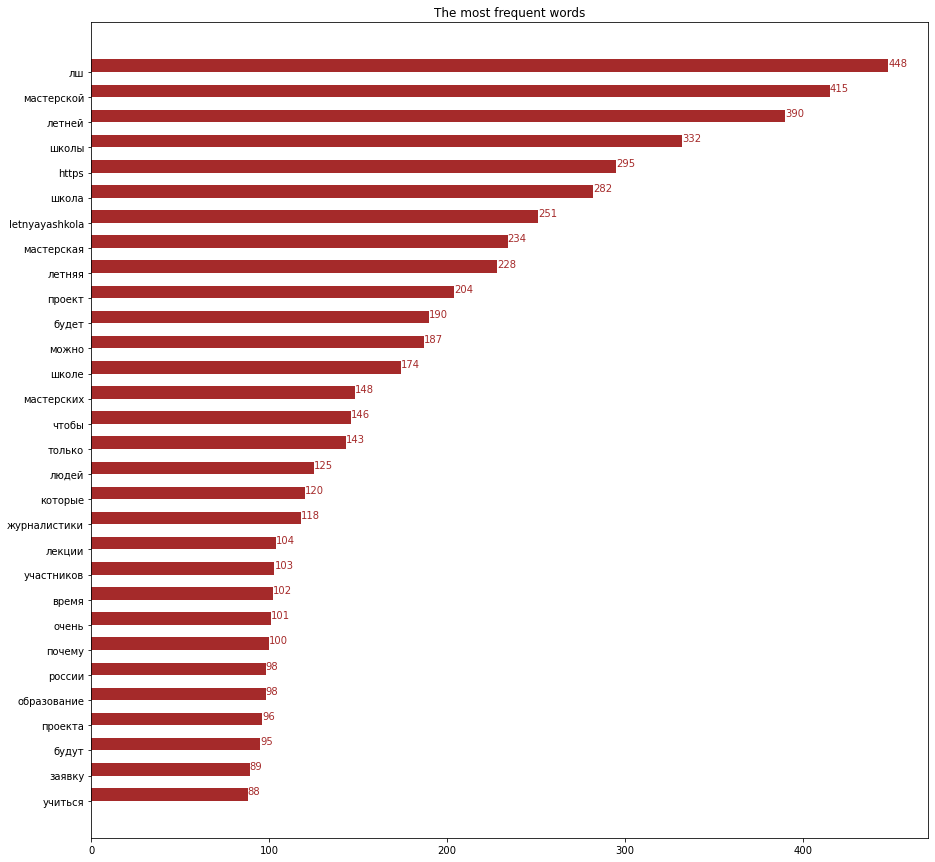

<Figure size 2880x2880 with 0 Axes>

In [15]:
# Вывод 50 самых частотных слов для постов админов
create_hist(trim_dict(create_sorted_dict(admin_posts), 30))

Number of unique words : 21928
Number of all words : 81080
Number of 30 most frequent words : 8527
30 most frequent words is 0.14% of unique words and 10.52% of all words


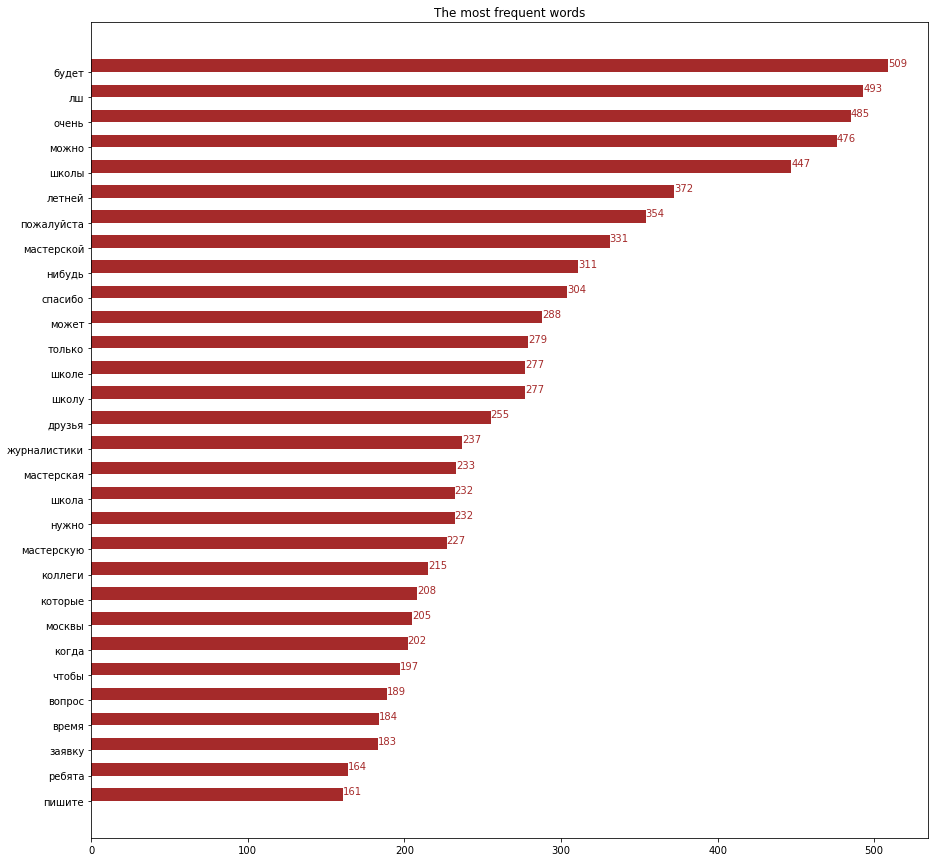

<Figure size 2880x2880 with 0 Axes>

In [16]:
# Вывод 50 самых частотных слов для постов пользователей
create_hist(trim_dict(create_sorted_dict(user_posts), 30))

Number of unique words : 26849
Number of all words : 101930
Number of 30 most frequent words : 10582
30 most frequent words is 0.11% of unique words and 10.38% of all words


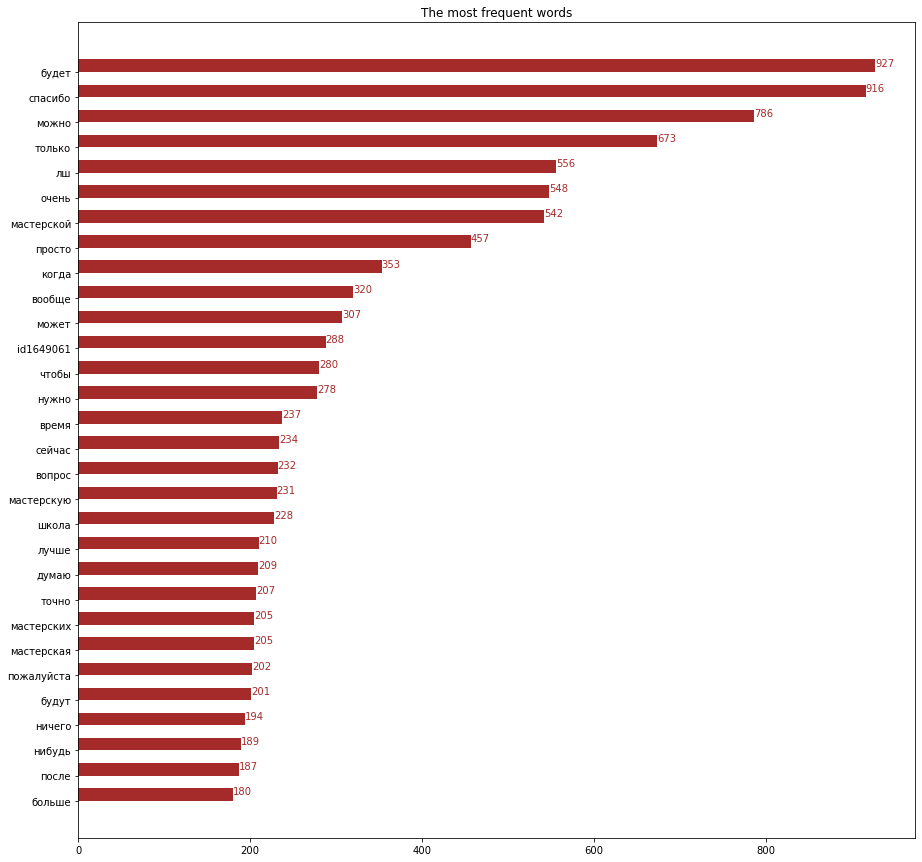

<Figure size 2880x2880 with 0 Axes>

In [17]:
# Вывод 50 самых частотных слов для комментариев
create_hist(trim_dict(create_sorted_dict(comments), 30))